In [16]:
pd.options.display.max_rows = 1500
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
# import statsmodels.api as sm

# Preprocessing and Pipeline libraries
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
import pickle


C:\Users\spashikanti\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
print("\nLoading training data...")
# load training data
train_data = pd.read_csv("Data/peerLoanTraining.csv", engine='python', header=0)

# Separate out X and y
X_train = train_data.loc[:, train_data.columns != 'is_late']
y_train = train_data['is_late']

print("\nLoading test data...")
# load test data
test_data = pd.read_csv("Data/peerLoanTest.csv", engine='python', header=0)

# Separate out X and y
X_test = test_data.loc[:, test_data.columns != 'is_late']
y_test = test_data['is_late']

print("\nLoaded training & test data")


Loading training data...

Loading test data...

Loaded training & test data


In [4]:
def SummaryTable(df):
    print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
    print("\n","TOP FEW OBSERVATIONS:")
    print(display(df.head(5)))
    print("\n","BOTTOM FEW OBSERVATIONS:")
    print(display(df.tail(5)))
    print("\n","SUMMARY of Quantitative Data:")
    print(display(df.describe()),"\n")
    summary = pd.DataFrame(df.dtypes,columns=['DataType'])
    summary = summary.reset_index()
    summary['VariableName'] = summary['index']
    summary = summary[['VariableName','DataType']]
    summary['Missing'] = df.isnull().sum().values
    summary['MissingPercentage'] = (df.isnull().sum().values/len(df)*100).round(2)
    summary['Uniques'] = df.nunique().values
#     summary['First Value'] = df.loc[0].values
#     summary['Second Value'] = df.loc[1].values
#     summary['Third Value'] = df.loc[2].values
#     summary['Fourth Value'] = df.loc[3].values
#     summary['Fifth Value'] = df.loc[4].values
    
#     for name in summary['VariableName'].value_counts().index:
#         summary.loc[summary['VariableName'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    categorical_features = df.select_dtypes(include = np.object)
    print("Frequency of Categorical Data:","\n")
    for i in categorical_features.columns:
        print(i + ":" + str(categorical_features[i].nunique()))
        print(categorical_features[i].value_counts())
        print('\n')
    
    return summary

In [4]:
print("Summary of Training Data:")
SummaryTable(X_train)

Summary of Training Data:
This dataset has 111068 rows, and 10 columns
('\n', 'TOP FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
0,12000,0.2039,credit_card,D,42000.0,0.647,10+ years,14.46,0,RENT
1,29150,0.2039,home_improvement,D,51000.0,0.404,10+ years,20.82,0,MORTGAGE
2,8000,0.1306,other,C,73000.0,0.560,10+ years,33.27,0,MORTGAGE
3,21000,0.0746,credit_card,A,60000.0,0.395,NaN,22.42,0,OWN
4,13000,0.1747,debt_consolidation,D,27500.0,0.185,4 years,26.45,0,RENT


None
('\n', 'BOTTOM FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
111063,6800,0.1601,debt_consolidation,C,20000.0,0.287,10+ years,25.03,1,MORTGAGE
111064,3000,0.2039,other,D,72000.0,0.605,10+ years,5.87,0,RENT
111065,14000,0.1601,debt_consolidation,C,52874.0,0.850,10+ years,22.36,0,MORTGAGE
111066,7500,0.1090,other,B,126000.0,0.283,10+ years,6.33,0,RENT
111067,35000,0.0607,debt_consolidation,A,110000.0,0.352,10+ years,9.80,0,RENT


None
('\n', 'SUMMARY of Quantitative Data:')


,loan_amnt,int_rate,annual_inc,revol_util,dti,delinq_2yrs
count,111068.000000,111068.000000,1.110680e+05,110951.000000,111068.000000,111068.000000
mean,15333.901304,0.123530,8.152713e+04,0.432369,17.334945,0.236450
std,9903.827140,0.049712,8.914149e+04,0.247957,8.750318,0.750367
min,1000.000000,0.053100,2.300000e+03,0.000000,0.000000,0.000000
25%,8000.000000,0.080800,4.800000e+04,0.236000,10.750000,0.000000
50%,12000.000000,0.119800,6.800000e+04,0.413000,16.700000,0.000000
75%,20000.000000,0.150400,9.800000e+04,0.616000,23.410000,0.000000
max,40000.000000,0.309900,9.930475e+06,1.244000,39.990000,23.000000


(None, '\n')
('Frequency of Categorical Data:', '\n')
purpose:12
debt_consolidation    53271
credit_card           29222
other                  9876
home_improvement       7679
major_purchase         3260
house                  2081
medical                1559
car                    1311
small_business         1038
vacation                938
moving                  772
renewable_energy         61
Name: purpose, dtype: int64


grade:7
B    32835
C    29884
A    29298
D    15082
E     3281
F      596
G       92
Name: grade, dtype: int64


emp_length:11
10+ years    37389
2 years      10577
3 years       9325
< 1 year      7615
1 year        7488
4 years       7445
5 years       7048
6 years       5282
7 years       4280
8 years       3753
9 years       3119
Name: emp_length, dtype: int64


home_ownership:4
MORTGAGE    49589
RENT        46766
OWN         14700
ANY            13
Name: home_ownership, dtype: int64




,VariableName,DataType,Missing,MissingPercentage,Uniques
0,loan_amnt,int64,0,0,1415
1,int_rate,float64,0,0,54
2,purpose,object,0,0,12
3,grade,object,0,0,7
4,annual_inc,float64,0,0,9589
5,revol_util,float64,117,0,1058
6,emp_length,object,7747,0,11
7,dti,float64,0,0,3996
8,delinq_2yrs,int64,0,0,20
9,home_ownership,object,0,0,4


In [5]:
SummaryTable(X_test)

This dataset has 6843 rows, and 10 columns
('\n', 'TOP FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
0,5000,0.1356,debt_consolidation,C,52000.0,0.226,9 years,14.39,1,MORTGAGE
1,25000,0.0611,credit_card,A,75000.0,0.300,1 year,32.94,0,RENT
2,12000,0.0846,debt_consolidation,A,70000.0,0.447,1 year,20.93,0,RENT
3,20000,0.1155,debt_consolidation,B,85000.0,0.785,10+ years,28.72,1,OWN
4,6400,0.1549,credit_card,C,46000.0,0.327,10+ years,18.76,0,RENT


None
('\n', 'BOTTOM FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
6838,8400,0.0846,credit_card,A,100000.0,0.070,< 1 year,4.98,0,MORTGAGE
6839,20000,0.1691,home_improvement,C,103000.0,0.415,10+ years,14.16,2,MORTGAGE
6840,8000,0.1614,credit_card,C,40000.0,0.106,10+ years,10.17,1,OWN
6841,20000,0.1047,credit_card,B,150000.0,0.642,8 years,7.67,2,RENT
6842,10000,0.1691,debt_consolidation,C,38000.0,0.290,5 years,19.58,3,RENT


None
('\n', 'SUMMARY of Quantitative Data:')


,loan_amnt,int_rate,annual_inc,revol_util,dti,delinq_2yrs
count,6843.000000,6843.000000,6843.000000,6836.000000,6843.000000,6843.000000
mean,15564.723075,0.128534,82371.544058,0.448347,17.638371,0.235423
std,9784.198677,0.052686,53271.511923,0.245049,8.595267,0.752054
min,1000.000000,0.053100,2951.000000,0.000000,0.000000,0.000000
25%,8312.500000,0.084600,50000.000000,0.254000,11.170000,0.000000
50%,13000.000000,0.115500,70000.000000,0.431000,16.950000,0.000000
75%,20000.000000,0.161400,100000.000000,0.630000,23.595000,0.000000
max,40000.000000,0.309900,987000.000000,1.050000,39.990000,18.000000


(None, '\n')
('Frequency of Categorical Data:', '\n')
purpose:12
debt_consolidation    3753
credit_card           1913
other                  386
home_improvement       380
major_purchase         115
medical                 68
vacation                53
car                     50
small_business          49
house                   40
moving                  32
renewable_energy         4
Name: purpose, dtype: int64


grade:7
A    2019
B    1882
C    1671
D     951
E     267
F      42
G      11
Name: grade, dtype: int64


emp_length:11
10+ years    2275
2 years       637
< 1 year      633
3 years       576
4 years       476
1 year        447
5 years       407
6 years       297
7 years       243
8 years       220
9 years       159
Name: emp_length, dtype: int64


home_ownership:4
MORTGAGE    3111
RENT        2908
OWN          813
ANY           11
Name: home_ownership, dtype: int64




,VariableName,DataType,Missing,MissingPercentage,Uniques
0,loan_amnt,int64,0,0,449
1,int_rate,float64,0,0,57
2,purpose,object,0,0,12
3,grade,object,0,0,7
4,annual_inc,float64,0,0,1014
5,revol_util,float64,7,0,986
6,emp_length,object,473,0,11
7,dti,float64,0,0,2934
8,delinq_2yrs,int64,0,0,12
9,home_ownership,object,0,0,4


#### Missing Value Analysis
* revol_util - Use Median
* emp_length - Use Mode

In [12]:
revol_util_median = X_train['revol_util'].median()
X_train['revol_util']=X_train['revol_util'].fillna(revol_util_median)
X_test['revol_util']=X_test['revol_util'].fillna(revol_util_median)

emp_length_mode = X_train['emp_length'].mode()
X_train['emp_length']=X_train['emp_length'].fillna(emp_length_mode[0])
X_test['emp_length']=X_test['emp_length'].fillna(emp_length_mode[0])

C:\Users\spashikanti\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\spashikanti\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\spashikanti\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

#### Categorical Data 
* Grade is Ordinal & related to Interest rate
* 


In [28]:
# A [0.5,0.08], B 0.06,[0.0943,0.1213], C 0.06,[0.1261,0.1646], D 0.06,[0.1709,0.2185], E 0.06,[0.229,0.2677], F [0.2872,0.3075], G [0.3079,0.3099]
pd.crosstab(X_train['grade'],X_train['int_rate'])

int_rate,0.0531,0.06,0.0607,0.0619,0.0671,0.0683,0.0734,0.0735,0.0746,0.0796,0.0808,0.0943,0.0958,0.0992,0.1007,0.1041,0.1056,0.109,0.1105,0.1198,0.1213,0.1261,0.1306,0.1358,0.1403,0.1407,0.1452,0.1504,0.1549,0.1601,0.1646,0.1709,0.1747,0.1806,0.1845,0.1942,0.2,0.2039,0.2185,0.229,0.2387,0.2484,0.2581,0.2677,0.2872,0.2969,0.3017,0.3065,0.3075,0.3079,0.3084,0.3089,0.3094,0.3099
grade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,5576,4,2560,2704,2865,3255,3178,2,3572,2549,3033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,3,0,0,0,0,0,0,0,0,0,3308,3309,3233,3493,2372,2751,3550,3799,3454,3563,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3277,3417,2900,3206,2858,3056,2725,3029,2664,2747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3562,1,3369,2966,1,2675,2501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,535,460,724,611,950,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,352,83,64,48,49,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,10,6,2,3


[Text(0,0,'D'),
 Text(0,0,'C'),
 Text(0,0,'A'),
 Text(0,0,'E'),
 Text(0,0,'B'),
 Text(0,0,'F'),
 Text(0,0,'G')]

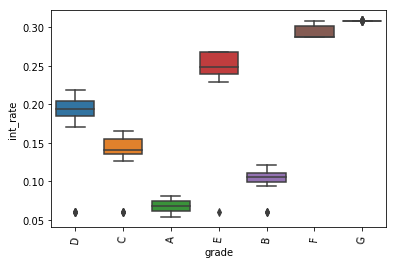

In [27]:
chart = sns.boxplot(x="grade", y="int_rate", data=X_train)
chart.set_xticklabels(chart.get_xticklabels(), rotation=85)

[Text(0,0,'credit_card'),
 Text(0,0,'home_improvement'),
 Text(0,0,'other'),
 Text(0,0,'debt_consolidation'),
 Text(0,0,'major_purchase'),
 Text(0,0,'moving'),
 Text(0,0,'house'),
 Text(0,0,'medical'),
 Text(0,0,'small_business'),
 Text(0,0,'vacation'),
 Text(0,0,'car'),
 Text(0,0,'renewable_energy')]

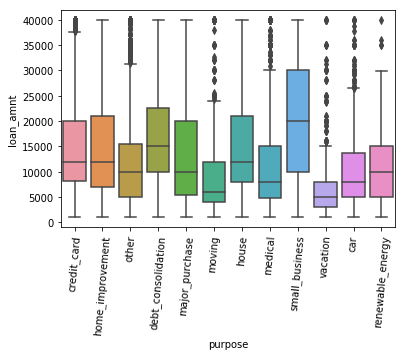

In [26]:
chart = sns.boxplot(x="purpose", y="loan_amnt", data=X_train)
chart.set_xticklabels(chart.get_xticklabels(), rotation=85)

In [11]:
emp_length_mode[0]

'10+ years'

In [14]:
SummaryTable(X_train)

This dataset has 111068 rows, and 10 columns
('\n', 'TOP FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
0,12000,0.2039,credit_card,D,42000.0,0.647,10+ years,14.46,0,RENT
1,29150,0.2039,home_improvement,D,51000.0,0.404,10+ years,20.82,0,MORTGAGE
2,8000,0.1306,other,C,73000.0,0.560,10+ years,33.27,0,MORTGAGE
3,21000,0.0746,credit_card,A,60000.0,0.395,10+ years,22.42,0,OWN
4,13000,0.1747,debt_consolidation,D,27500.0,0.185,4 years,26.45,0,RENT


None
('\n', 'BOTTOM FEW OBSERVATIONS:')


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
111063,6800,0.1601,debt_consolidation,C,20000.0,0.287,10+ years,25.03,1,MORTGAGE
111064,3000,0.2039,other,D,72000.0,0.605,10+ years,5.87,0,RENT
111065,14000,0.1601,debt_consolidation,C,52874.0,0.850,10+ years,22.36,0,MORTGAGE
111066,7500,0.1090,other,B,126000.0,0.283,10+ years,6.33,0,RENT
111067,35000,0.0607,debt_consolidation,A,110000.0,0.352,10+ years,9.80,0,RENT


None
('\n', 'SUMMARY of Quantitative Data:')


,loan_amnt,int_rate,annual_inc,revol_util,dti,delinq_2yrs
count,111068.000000,111068.000000,1.110680e+05,111068.000000,111068.000000,111068.000000
mean,15333.901304,0.123530,8.152713e+04,0.432349,17.334945,0.236450
std,9903.827140,0.049712,8.914149e+04,0.247827,8.750318,0.750367
min,1000.000000,0.053100,2.300000e+03,0.000000,0.000000,0.000000
25%,8000.000000,0.080800,4.800000e+04,0.236000,10.750000,0.000000
50%,12000.000000,0.119800,6.800000e+04,0.413000,16.700000,0.000000
75%,20000.000000,0.150400,9.800000e+04,0.615000,23.410000,0.000000
max,40000.000000,0.309900,9.930475e+06,1.244000,39.990000,23.000000


(None, '\n')
('Frequency of Categorical Data:', '\n')
purpose:12
debt_consolidation    53271
credit_card           29222
other                  9876
home_improvement       7679
major_purchase         3260
house                  2081
medical                1559
car                    1311
small_business         1038
vacation                938
moving                  772
renewable_energy         61
Name: purpose, dtype: int64


grade:7
B    32835
C    29884
A    29298
D    15082
E     3281
F      596
G       92
Name: grade, dtype: int64


emp_length:11
10+ years    45136
2 years      10577
3 years       9325
< 1 year      7615
1 year        7488
4 years       7445
5 years       7048
6 years       5282
7 years       4280
8 years       3753
9 years       3119
Name: emp_length, dtype: int64


home_ownership:4
MORTGAGE    49589
RENT        46766
OWN         14700
ANY            13
Name: home_ownership, dtype: int64




,VariableName,DataType,Missing,MissingPercentage,Uniques
0,loan_amnt,int64,0,0,1415
1,int_rate,float64,0,0,54
2,purpose,object,0,0,12
3,grade,object,0,0,7
4,annual_inc,float64,0,0,9589
5,revol_util,float64,0,0,1058
6,emp_length,object,0,0,11
7,dti,float64,0,0,3996
8,delinq_2yrs,int64,0,0,20
9,home_ownership,object,0,0,4


('FREQUENCY OF TARGET: \n', 0    108608
1      2460
Name: is_late, dtype: int64)


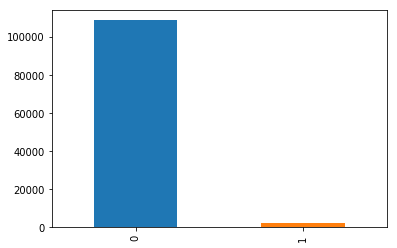

In [11]:
print("FREQUENCY OF TARGET: \n",pd.value_counts(y_train))
y_train.value_counts().plot.bar()

# Data is HIGHLY IMBALANCED

* loan_amnt 
* emp_length - Create a new category for missing data

In [222]:
X_train = X_train.assign(ID=pd.Series(range(1,len(X_train))))

In [103]:
numerical_features = X_train.select_dtypes(include = np.number)
categorical_features = X_train.select_dtypes(include = np.object)
print("Numerical Features:", numerical_features.shape[1] ,"\n", numerical_features.columns)
print('\n')
print("Cateogrical Features:", categorical_features.shape[1] ,"\n", categorical_features.columns)

Numerical Features: 6 
 Index(['loan_amnt', 'int_rate', 'annual_inc', 'revol_util', 'dti',
       'delinq_2yrs'],
      dtype='object')


Cateogrical Features: 4 
 Index(['purpose', 'grade', 'emp_length', 'home_ownership'], dtype='object')


In [105]:
numerical_features.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'revol_util', 'dti',
       'delinq_2yrs'],
      dtype='object')

In [ ]:
def woe(X, y, cont=True):
    tmp = pd.DataFrame()
    tmp["variable"] = X
    if cont:
        tmp["variable"] = pd.qcut(tmp["variable"], 255, duplicates="drop")
    tmp["target"] = y
    var_counts = tmp.groupby("variable")["target"].count()
    var_events = tmp.groupby("variable")["target"].sum()
    var_nonevents = var_counts - var_events
    tmp["var_counts"] = tmp.variable.map(var_counts)
    tmp["var_events"] = tmp.variable.map(var_events)
    tmp["var_nonevents"] = tmp.variable.map(var_nonevents)
    events = sum(tmp["target"] == 1)
    nonevents = sum(tmp["target"] == 0)
    tmp["woe"] = np.log(((tmp["var_nonevents"])/nonevents)/((tmp["var_events"])/events))
    tmp["woe"] = tmp["woe"].replace(np.inf, 0).replace(-np.inf, 0)
    tmp["iv"] = (tmp["var_nonevents"]/nonevents - tmp["var_events"]/events) * tmp["woe"]
    iv = tmp.groupby("variable")["iv"].last().sum()
    return tmp["woe"], tmp["iv"], iv

## Numerical

In [147]:
numerical_features = train_data.select_dtypes(include = np.number)

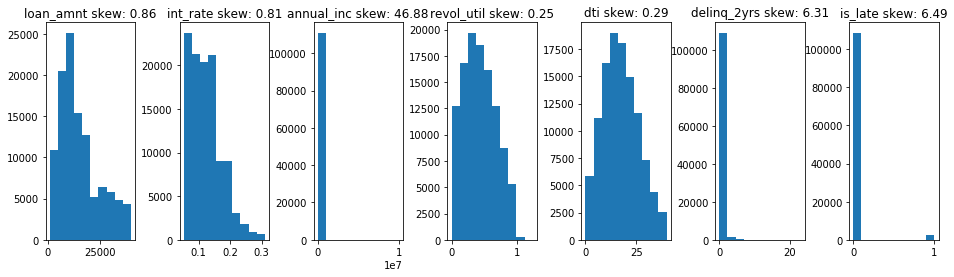

In [229]:
# Histogram for Numerical Vars
fig, axes = plt.subplots(1,7 , figsize = (16,4))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axes = axes.ravel()
for i,j in zip([i for i in numerical_features.columns[0:]], range(10)):
    axes[j].hist(numerical_features[i])
    axes[j].set_title(i+' skew: '+str(np.round(numerical_features[i].skew(),2)))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


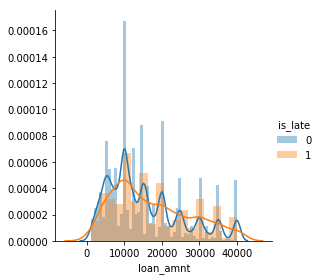

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


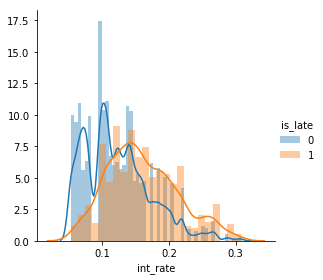

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


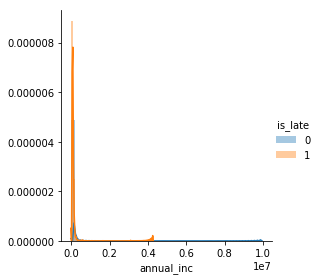

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


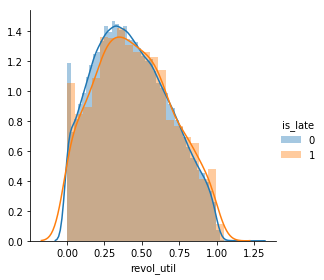

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


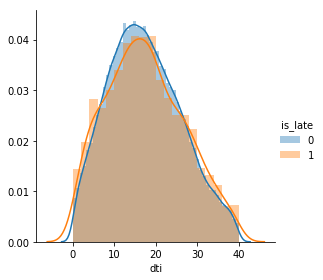

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


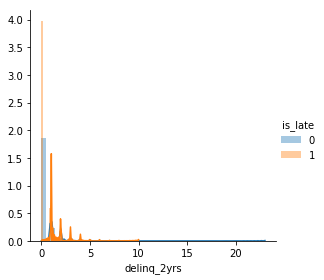

In [106]:
# Numerical Vars
for i in numerical_features.columns: #['loan_amnt','int_rate']
    sns.FacetGrid(train_data, hue='is_late', size=4) \
        .map(sns.distplot, i) \
        .add_legend()
    plt.show()

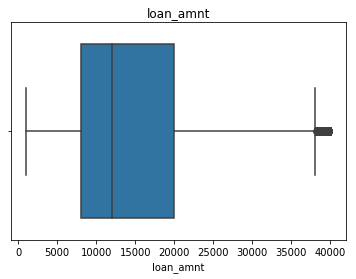

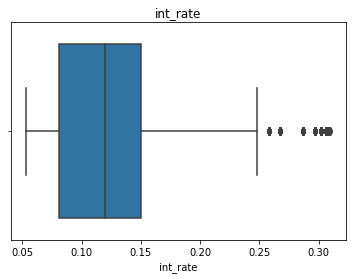

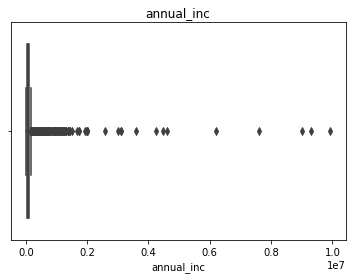

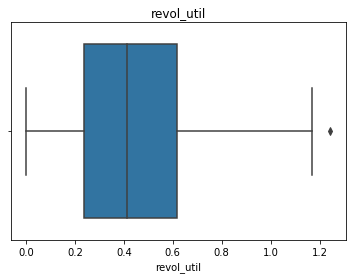

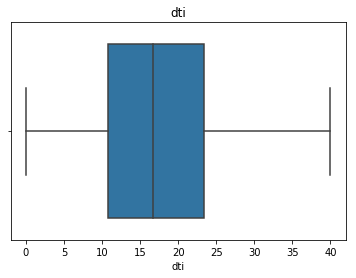

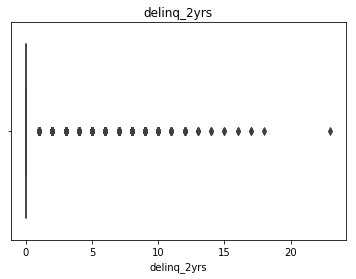

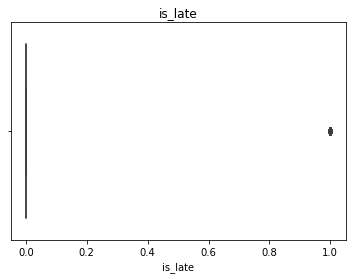

In [159]:
# Box Plot
for i in numerical_features:
    plt.figure()
    plt.clf()
    sns.boxplot(numerical_features[i])
    plt.title(i)
    plt.show()

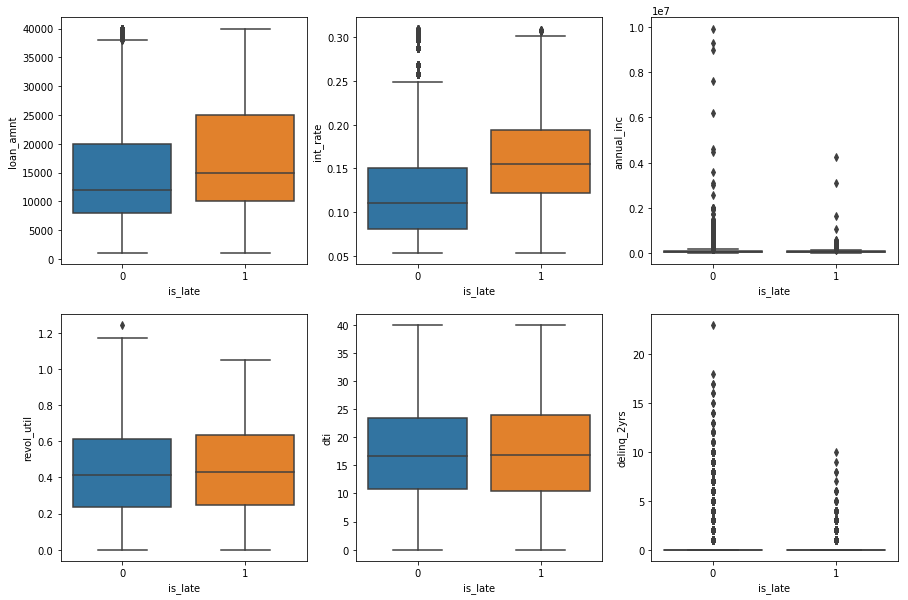

In [317]:
# Box Plot of Numerical Variable by Target Variable
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
AX = ax.ravel()

for i,j in zip([i for i in numerical_features.columns[0:]],AX):
    sns.boxplot(x = 'is_late', y = i, data =numerical_features,ax=j)

## Categorical Data

In [330]:
# Cross Tab of Categorical Vars by Target Variable: Freq & Percentage
for i in categorical_features.columns:
    print(i + ":" + str(categorical_features[i].nunique()))
#     print(pd.concat([pd.crosstab(train_data[i], train_data['is_late'], margins=True),
#                    pd.crosstab(train_data[i], train_data['is_late'], normalize='index')]))
    Df = pd.concat([pd.DataFrame(pd.crosstab(train_data[i], train_data['is_late'], margins=True)),
                    pd.DataFrame(train_data[i].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'),
                   pd.DataFrame(pd.crosstab(train_data[i], train_data['is_late'], normalize='index')).mul(100).round(1).astype(str) + '%'], axis=1, sort=False)
    Df.columns = ['Target_0', 'Target_1', 'Freq','FreqPercent',"Target_Percent0","Target_Percent1"]
    
    print(Df)
    print('\n')

purpose:12
                    Target_0  Target_1    Freq FreqPercent Target_Percent0  \
car                     1287        24    1311        1.2%           98.2%   
credit_card            28769       453   29222       26.3%           98.4%   
debt_consolidation     52028      1243   53271       48.0%           97.7%   
home_improvement        7499       180    7679        6.9%           97.7%   
house                   2028        53    2081        1.9%           97.5%   
major_purchase          3168        92    3260        2.9%           97.2%   
medical                 1503        56    1559        1.4%           96.4%   
moving                   749        23     772        0.7%           97.0%   
other                   9616       260    9876        8.9%           97.4%   
renewable_energy          59         2      61        0.1%           96.7%   
small_business           986        52    1038        0.9%           95.0%   
vacation                 916        22     938       

In [283]:
# Frequency table for each catergorical variable
# Cross tab of Categorical variable vs Target Variable
for i in categorical_features.columns:
    print(i + ":" + str(categorical_features[i].nunique()))
    print(categorical_features[i].value_counts(), "\n",pd.crosstab(train_data[i], train_data['is_late']))
    print('\n')

purpose:12
debt_consolidation    53271
credit_card           29222
other                  9876
home_improvement       7679
major_purchase         3260
house                  2081
medical                1559
car                    1311
small_business         1038
vacation                938
moving                  772
renewable_energy         61
Name: purpose, dtype: int64 
 is_late                 0     1
purpose                        
car                  1287    24
credit_card         28769   453
debt_consolidation  52028  1243
home_improvement     7499   180
house                2028    53
major_purchase       3168    92
medical              1503    56
moving                749    23
other                9616   260
renewable_energy       59     2
small_business        986    52
vacation              916    22


grade:7
B    32835
C    29884
A    29298
D    15082
E     3281
F      596
G       92
Name: grade, dtype: int64 
 is_late      0    1
grade              
A        29140  158


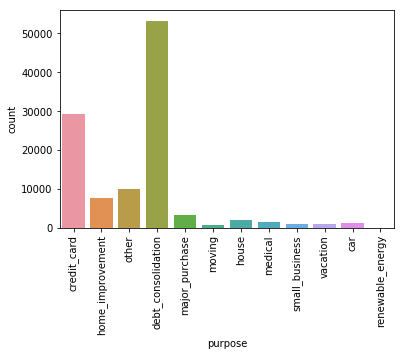

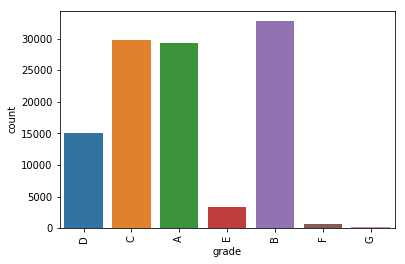

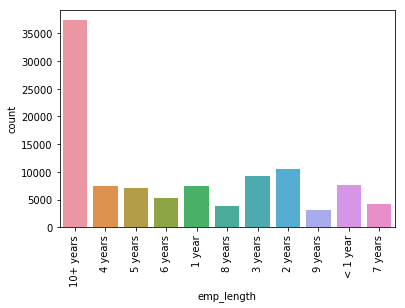

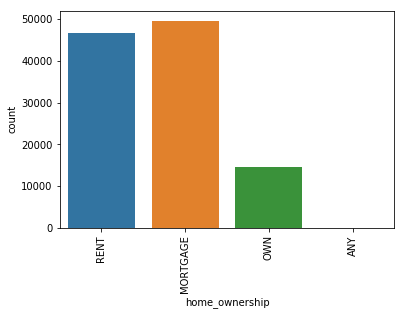

In [107]:
# Frequncy - Bar Graph for Categorical Variables
for i in categorical_features: #['purpose','grade']
    chart = sns.countplot(data=train_data,x=i)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

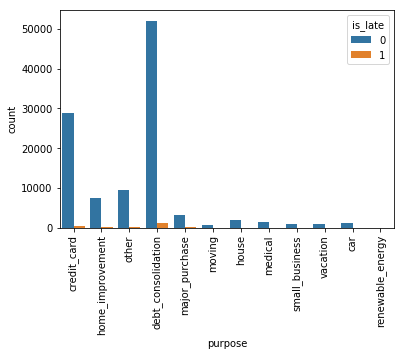

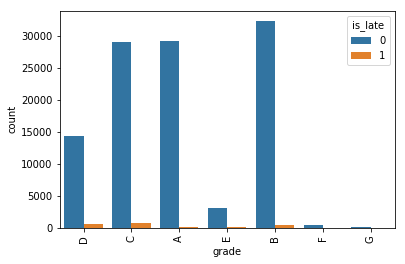

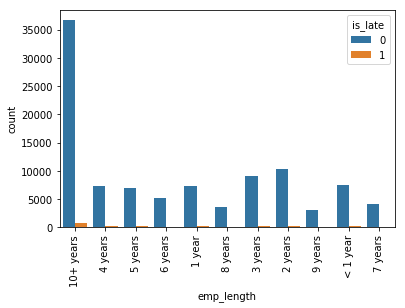

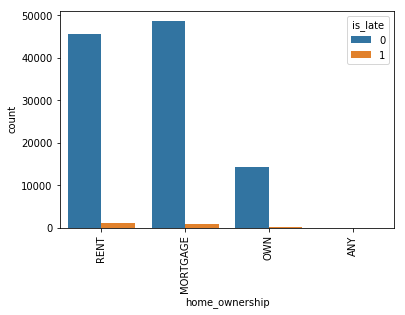

In [138]:
# Cross Tab - Bar Graph for Categorical Variables by Target Variable
for i in categorical_features: #['purpose','grade']
    chart = sns.countplot(data=train_data,x=i, hue="is_late")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

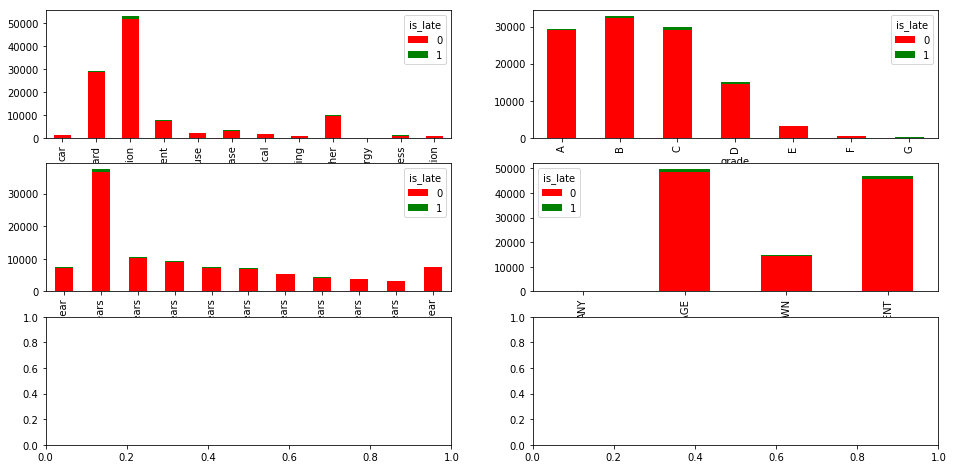

In [143]:
# Cross Tab - Categorical Variable by Target Variable (Stacked Bar Plot)
fig, axes = plt.subplots(3,2, figsize = (16,8))
axes = axes.ravel()

for i,j in zip([i for i in categorical_features.columns], axes):
    temp = pd.crosstab(train_data[i], train_data['is_late'])
    temp.plot(kind = 'bar', stacked = True, color = ['red', 'green'] , grid = False, ax = j)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


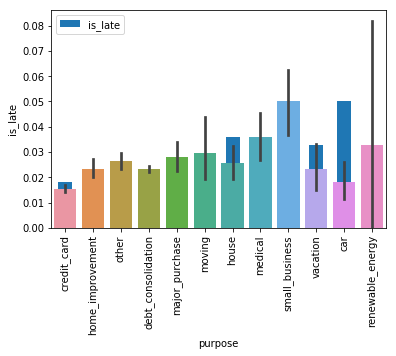

In [52]:
# Grouping by purpose
train_data[['purpose','is_late']].groupby('purpose').mean().plot.bar()
sns.barplot('purpose', 'is_late', data = train_data)
plt.show()

In [160]:
import pandas_profiling as pp

ModuleNotFoundError: No module named 'pandas_profiling'